# Jupyter Notebook to create grad cam images

In [18]:
import tensorflow as tf
import cv2
import glob
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model

np.random.seed(42)
tf.random.set_seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Grad Cam class to take the activations from the last conv layer and build a heatmap

In [19]:

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            print(self.model.layers)
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)

            loss = predictions[:, tf.argmax(predictions[0])]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

## Method to load the model.json and its weights.h5 from disk

In [20]:
def load_model(model_path, weight_path):
    # load json and create model
    file = open(model_path, 'r')
    model_json = file.read()
    file.close()
    loaded_model = keras.models.model_from_json(model_json)
    # load weights
    loaded_model.load_weights(weight_path)
    optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
    loaded_model.compile(loss="binary_crossentropy", optimizer=optimizer,
                         metrics=['accuracy', 'Recall', 'Precision', 'AUC'])
    return loaded_model

# Create grad cam images from set which was not used in training

In [21]:
model = load_model('saved_models/vgg16_heavily_reduced.json', 'saved_models/vgg16_heavily_reduced_weights.h5')

## Grad Cam image for single image

### load image from folder and convert to np array

In [22]:
image = cv2.imread('data/MyRecord2021-11-19T125431028-from_00_49_00.00.mp4-img-44016.jpg')
image = cv2.resize(image, (224, 224))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

### used model to predict outcome of image and select the top prediction with argmax

In [23]:
preds = model.predict(image)
i = np.argmax(preds[0])

### use GradCam on model with the highest prediction and get activation from last conv layer of model
* compute heatmap
* put heatmap over original image
* plot outputs

In [24]:
icam = GradCAM(model, i, 'block5_conv3')
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread('data/MyRecord2021-11-19T125431028-from_00_49_00.00.mp4-img-44016.jpg')
image = cv2.resize(image, (224, 224))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)


(224, 224) (224, 224, 3)


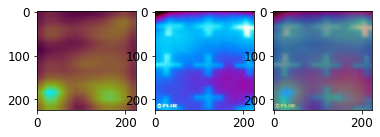

In [25]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

save images

In [104]:
img_heatmap = keras.preprocessing.image.array_to_img(heatmap)
img_output = keras.preprocessing.image.array_to_img(output)
img_heatmap.save('heatmap.jpg')
img_output.save('output.jpg')

## Multiple Images

### load multiple images from folder and create arrays containing images converted to np.array

In [37]:
filenames = glob.glob('data/data_heavily_reduced/data/OK/*jpg')
filenames.sort()
print(len(filenames))
images = [cv2.imread(img) for img in filenames]
images = [cv2.resize(img,(224,224)) for img in images]
images = [(img.astype('float32') / 255) for img in images ]
images = [np.expand_dims(img, axis=0) for img in images]

4999


### save predictions, max-predictions and gradcams in arrays

In [38]:
predictions = [model.predict(img) for img in images]
max_predictions = [np.argmax(i[0]) for i in predictions]
icams = [GradCAM(model, i, 'block5_conv3') for i in max_predictions]

### generate heatmaps and save in array

In [39]:
heatmaps = [icam.compute_heatmap(img) for icam, img in zip(icams, images)]
heatmaps = [cv2.resize(heatmap, (244,244)) for heatmap in heatmaps]

### load start images and add heatmap with cv2.addWeighted

In [40]:
images = [cv2.imread(img) for img in filenames]
images = [cv2.resize(img,(224,224)) for img in images]
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]

outputs = []
for a,i in zip(heatmaps, images):
    a = cv2.applyColorMap(a, cv2.COLORMAP_JET)
    img2_resized = cv2.resize(a, (i.shape[1], i.shape[0]))
    outputs.append(cv2.addWeighted(i, 0.5, img2_resized, 1 - 0.5, 0))

### plot first 100 images

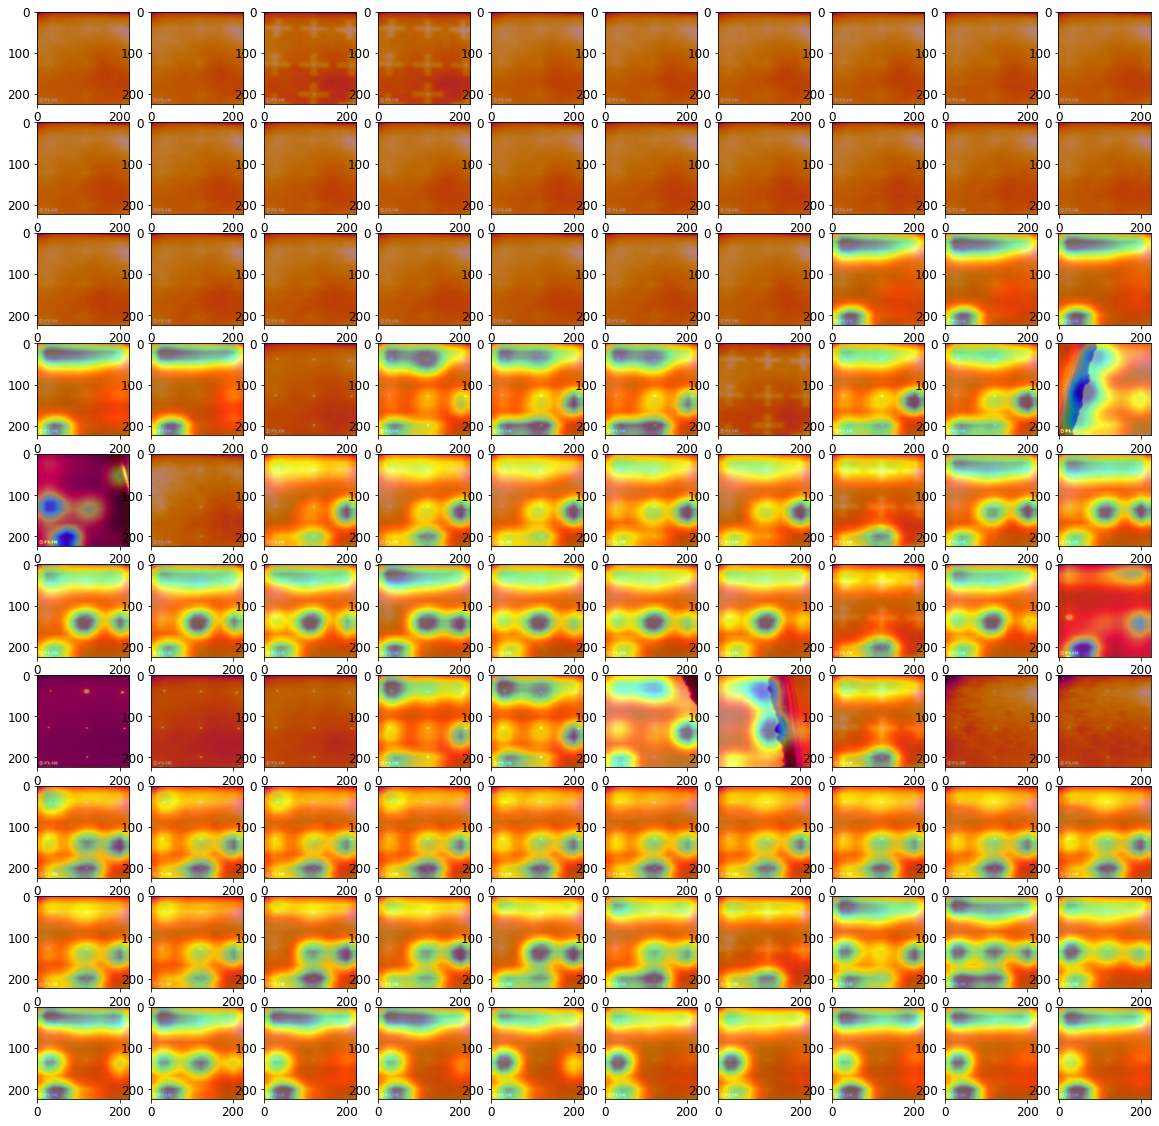

In [41]:
w = 20
h = 20
fig = plt.figure(figsize=(20, 20))
columns = 10
rows = 10
for i, img in zip(range(1, columns*rows +1), outputs):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

### save start images and overlaid versions

In [42]:
image_output = [keras.preprocessing.image.array_to_img(img) for img in images]
[out.save(str(id) + '_img' + '.jpg') for id, out in enumerate(image_output)]

img_output = [keras.preprocessing.image.array_to_img(output) for output in outputs]
[out.save(str(id) + '_overlay' + '.jpg') for id, out in enumerate(img_output)]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,